## `Stock Price Prediction Using ML`

In [46]:
"""Import Packages"""

import datetime as dt
from typing import Any
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler

In [60]:
import tensorflow_keras

print(keras.__version__)

2.12.0


### Fetching ticker data

In [62]:
class DataStock:
    def __init__(self, ticker: str, start: dt.datetime, end: dt.datetime )-> None:
        self.ticker: str = ticker
        self.start: dt.datetime = start
        self.end: dt.datetime = end

    def data_stock(self) -> pd.DataFrame:
         return pdr.get_data_stooq(self.ticker, self.start, self.end)[: : -1]
    
ticker = 'GOOG'
ticker_data: DataStock = DataStock(ticker, dt.datetime(2018, 1, 1), dt.datetime(2023, 4, 11))
dataframe: pd.DataFrame = ticker_data.data_stock()
dataframe.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-04-11,106.92,107.22,105.2800,106.12,18721278
2023-04-10,107.39,107.97,105.6000,106.95,19741517
2023-04-06,105.77,109.63,104.8150,108.90,34684150
2023-04-05,106.12,106.54,104.1021,104.95,21864200
2023-04-04,104.84,106.10,104.6000,105.12,20377231


In [48]:
class Plotter:
    def __init__(self, title: str, xlabel: str, ylabel: str, legend: str) -> None:
        plt.style.use('fivethirtyeight')
        plt.style.use('dark_background')
        
        self.title: str = title
        self.xlabel: str = xlabel
        self.ylabel: str = ylabel
        self.legend: str = legend
        
    def plot_before_training(self, x) -> None:
        plt.figure(figsize=(10, 5))
        plt.title(self.title)
        plt.plot(x, color='b')
        plt.xlabel(self.xlabel, fontsize=15)
        plt.ylabel(self.ylabel, fontsize=15)
        plt.legend([self.legend], loc='upper left')
        plt.show()
    
    def plot_after_training(self, train_close, valid_close, pred_close) -> None:
        plt.figure(figsize=(10, 5))
        plt.title(self.title)
        plt.plot(train_close, color='b', label='Training Data')
        plt.plot(valid_close, color='y', label='Validation Data')
        plt.plot(pred_close, color='r', label='Predicted Data')
        plt.xlabel(self.xlabel, fontsize=15)
        plt.ylabel(self.ylabel, fontsize=15)
        plt.legend(loc='upper left')
        plt.show()


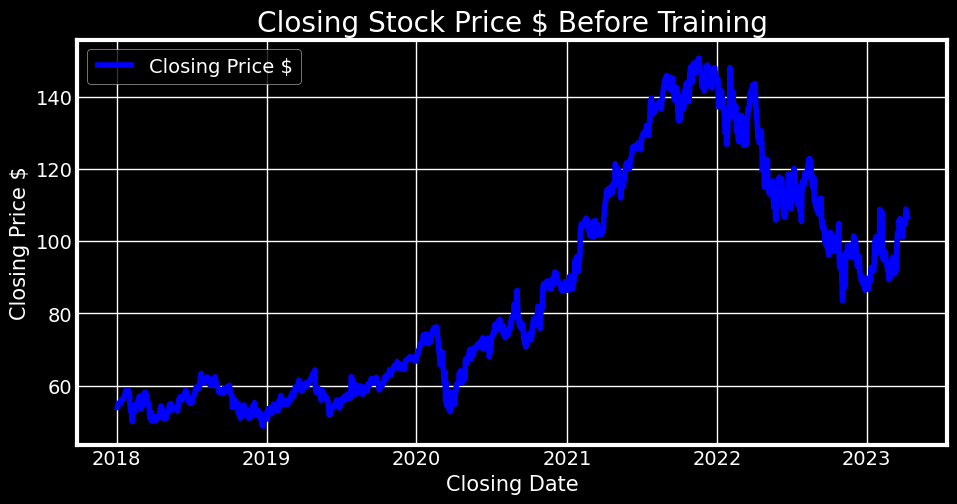

In [49]:
"""Plotting the closing price vs price"""
plotter_before_training: Plotter = Plotter(title='Closing Stock Price $ Before Training', 
                                           xlabel='Closing Date', 
                                           ylabel='Closing Price $', 
                                           legend='Closing Price $'
                                           )
plotter_before_training.plot_before_training(dataframe['Close'])

 

### Preprocessing the Data

In [50]:
"""Selecting the closing price"""
dataset: np.ndarray[float, Any] = dataframe.filter(['Close']).values
dataset[0], dataset.shape, type(dataset)

(array([53.245]), (1327, 1), numpy.ndarray)

In [51]:
# Splitting the dataset the to 80% training & 20% testing
data_training_length: int = np.ceil(len(dataset) * 0.8).astype(int)  

data_training_length

1062

In [52]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data: np.ndarray[float, Any] = scaler.fit_transform(dataset)
scaled_data[0], len(scaled_data), type(scaled_data)

(array([0.0435141]), 1327, numpy.ndarray)

### Creating Training Dataset

In [53]:
# Splitting the scaled_data into x_train and y_train
train_data: np.ndarray[float, Any] = scaled_data[0: data_training_length, :]
print(f'{data_training_length = }, {train_data[0] = }')

#split the data
x_train: np.ndarray[float, Any] = [] # input
y_train: np.ndarray[float, Any]= [] # Output

for idx in range(60, len(train_data)):
    x_train.append(train_data[idx - 60: idx, 0])
    y_train.append(train_data[idx, 0])

x_train = np.array(x_train) 
y_train = np.array(y_train)

# Reshaping the x_train fro ma 2D -> 3D array to use with LSTM
x_train = x_train[:, :, np.newaxis]
x_train[0][0], x_train.shape, type(x_train) 

data_training_length = 1062, train_data[0] = array([0.0435141])


(array([0.0435141]), (1002, 60, 1), numpy.ndarray)

### Testing Dataset

In [54]:
# Creating Testing dataset
test_data: np.ndarray[float, Any] = scaled_data[data_training_length - 60:, :]
x_test: np.ndarray[float, Any] = np.array([test_data[i - 60: i, 0] for i in range(60, len(test_data))])
y_test: np.ndarray[float, Any] = dataset[data_training_length:, :]

# Reshaping from 2D to 3D for the model
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test = x_test[:, :, np.newaxis]

print(f'{test_data[0] = }, {test_data.shape = }, {type(test_data) = }')
print(f'{x_test[0][0] = }, {x_test.shape = }, {type(x_test) = }')
print(f'{y_test[0][0] = }, {y_test.shape = }, {type(y_test) = }')

test_data[0] = array([0.96499441]), test_data.shape = (325, 1), type(test_data) = <class 'numpy.ndarray'>
x_test[0][0] = array([0.96499441]), x_test.shape = (265, 60, 1), type(x_test) = <class 'numpy.ndarray'>
y_test[0][0] = 140.278, y_test.shape = (265, 1), type(y_test) = <class 'numpy.ndarray'>


### Training The Model

In [55]:
# Sequential model
def create_model() -> Sequential:
    return Sequential([
        LSTM(128, 
             return_sequences=True, 
             input_shape=(x_train.shape[1], 1), 
             kernel_regularizer=regularizers.l2(0.01), 
             name='LSTM_128'),
        Dropout(0.2, name='Dropout_0.2'),
        LSTM(64, return_sequences=True, name='LSTM_64'),
        LSTM(32, return_sequences=False, name='LSTM_32'),
        Dense(16, name='Denso_16'),
        Dense(1, name='Dense_1'),
    ])

model: Sequential = create_model()

model.compile(optimizer='adam', loss='mean_squared_error')

log_dir: str = "logs/stock_prediction/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir)

batch_size: int = 1
epochs: int = 2

model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs,
        #   validation_data=(x_test, y_test), 
        #   callbacks=[tensorboard_callback]
          )

model.summary()

Epoch 1/2
1002/1002 [==============================] - 56s 50ms/step - loss: 0.0081
Epoch 2/2
1002/1002 [==============================] - 49s 49ms/step - loss: 0.0037
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_128 (LSTM)             (None, 60, 128)           66560     
                                                                 
 Dropout_0.2 (Dropout)       (None, 60, 128)           0         
                                                                 
 LSTM_64 (LSTM)              (None, 60, 64)            49408     
                                                                 
 LSTM_32 (LSTM)              (None, 32)                12416     
                                                                 
 Denso_16 (Dense)            (None, 16)                528       
                                                                 
 Dense_1 (Dense)  

### Model Prediction

In [56]:
# Model predicted values
predictions: np.ndarray[float, Any] = model.predict(x_test)
print(f'Unscaled: {predictions[0] = }')

# Model prediction unscaled
predictions = scaler.inverse_transform(predictions) 
print(f'Predictions After un-scaling: {predictions[0] = }')

# Evaluation with RMSE: Root Mean Squared Error
# RMSE = 0 => Model is exact
# The smaller the RMSE the Better
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'RMSE: {rmse:.2f}')

9/9 [==============================] - 2s 50ms/step
Unscaled: predictions[0] = array([0.8106056], dtype=float32)
Predictions After un-scaling: predictions[0] = array([131.4101], dtype=float32)
RMSE: 5.58


### Plotting the train, validation, and prediction

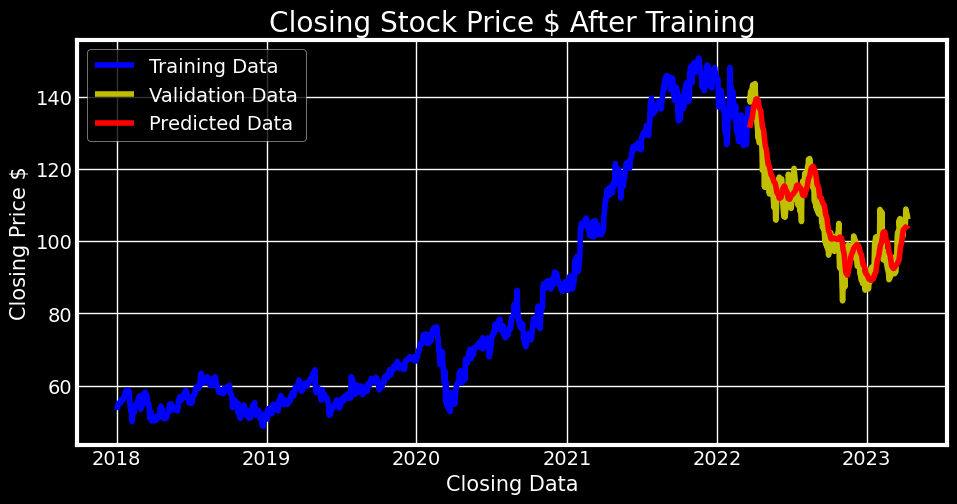

In [57]:
# Plotting the data
# slicing from 0 to the length 80%
train: pd.DataFrame = dataframe[: data_training_length]
# Validation data is the rest 20%
valid: pd.DataFrame = dataframe[data_training_length:].copy()
valid['Predictions'] = predictions
plotter_after_training: Plotter = Plotter(
    title='Closing Stock Price $ After Training', 
    xlabel='Closing Data', 
    ylabel='Closing Price $', 
    legend='Closing Price $'
    )
    
# Plot the data with custom formatting
plotter_after_training.plot_after_training(
    train['Close'], 
    valid['Close'], 
    valid['Predictions']
    )

## Testing the model on 90 last days 

### Preprocessing the data

In [58]:
# new_df: pd.DataFrame = apple_quote.data_stock()['Close']
new_df: pd.DataFrame = dataframe['Close']

# Get the last 90 days and convert to an array
last_90_days: np.ndarray[float, Any] = new_df[-90:].values
# print(f'\n{last_90_days[0] = }\n{last_60_days.shape = }')

# Reshaping the data
last_90_days: np.ndarray[float, Any] = last_90_days[:, np.newaxis]

# Scaling the data
last_90_days_scaled: np.ndarray[float, Any] = scaler.transform(last_90_days)

# Create an empty list
X_test: np.ndarray[float, Any] = np.array([last_90_days_scaled])

# Reshape 2D -> 3D for the LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape, X_test[0][0] 

# Get the predicted price
predict_price: np.ndarray[float, Any] = model.predict(X_test)
print(f'Before un-scaling:]\n{predict_price[0] = }')

# Undo the scaling
predict_price = scaler.inverse_transform(predict_price)
print(f'After un-scaling:]\n{predict_price[0] = }')

1/1 [==============================] - 3s 3s/step
Before un-scaling:]
predict_price[0] = array([0.5488275], dtype=float32)
After un-scaling:]
predict_price[0] = array([104.73543], dtype=float32)


### Model: Accuracy: %

In [59]:
# Testing the model
# one_day_dataframe: DataStock = DataStock(ticker, dt.datetime(2023, 4, 13), dt.datetime(2023, 4, 13))
# one_day_data: pd.DataFrame = one_day_dataframe.data_stock()['Close']
import numpy as np
real_price = dataset[-1]

# Compare
print(f'{predict_price[0][0] = } : ')
print(f'{real_price[0]= }')

print(f'Model Accuracy: {100 - np.abs(predict_price[0][0] - real_price[0]) / real_price[0] * 100:.2f}%')

predict_price[0][0] = 104.73543 : 
real_price[0]= 106.12
Model Accuracy: 98.70%
